# Question 1 - Combinatorial Logic Circuit using Neural Networks
I first determine the required truth table of the circuit given below, and train a two-layer ANN to classify the training examples. Note, there are three inputs. Also, two layers are enough for all boolean functions, and requires less time to train than larger networks, hence I have opted for that.

## Author: Rudraksh Kapil - 177154

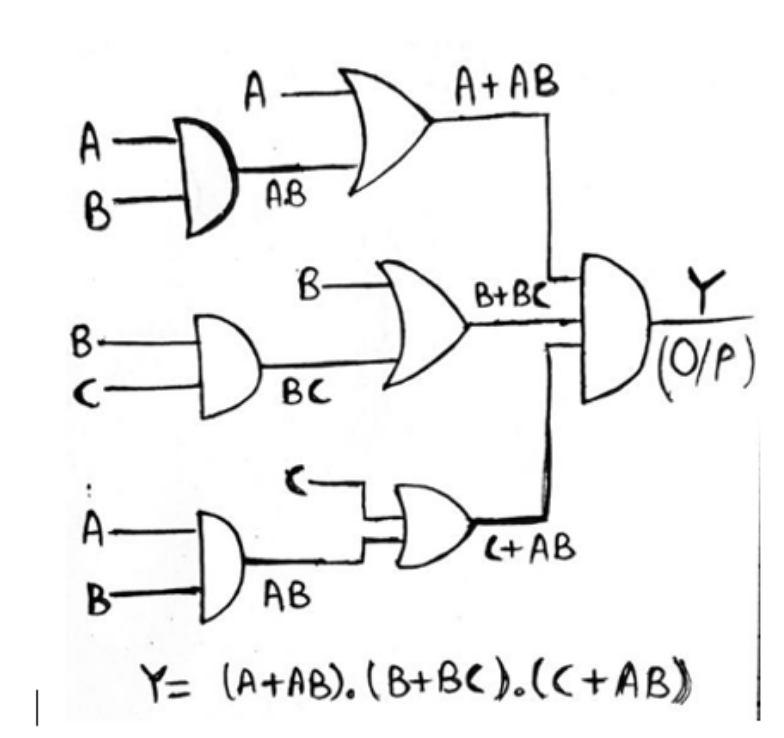

### Functions for neural network

In [147]:
# import statements
import numpy as np 
import pandas as pd 
import random
import matplotlib.pyplot as plt 
from tqdm import tqdm

###### Activation Function
We use a sigmoid activation function to calculate output of a unit.

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

###### Prediction Function
Predicts output given X and weights; returns accuracy. The y value to be passed to it should be in one-hot encoding format (OH format).

In [4]:
# checks accuracy
# bias is set to True if we're using 2 bit truth tables as input 
#(3rd bias term x0 is to be appended)
def predict(X, y, w1, w2, verbose=True, bias=True, show_all=False):
    # prediction in OH format will be stored in this list for each example
    y_pred = [] 
    
    # run through the network (forward pass only) for each X sample to get prediction
    for x in X:
        h = sigmoid(x.dot(w1.T))
        if (bias):
            temp_h = np.append(np.ones(1), h) # we dont want to add a bias term to h itself
        else:
            temp_h = h
        o = sigmoid(temp_h.dot(w2.T))
        
        # store prediction for this sample
        y_pred.append(o)
        
    # convert Y and Y_pred back from OH format to 1d array
    # our prediction is the index with highest value in y_pred hence using argmax
    y = np.argmax(y, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
                
    # for debugging print the labels for all pictures
    if show_all:
        for idx,x in enumerate(X):
            print(f"Predicted => {y_pred[idx]}, Actual => {y[idx]}")
            plt.imshow(x.reshape(28,28))
            plt.show()
    
    # calculate and return accuracy - this is why we had to reconvert back from OH format
    accuracy = np.mean(y_pred==y)
    if (verbose):
        print(f"Accuracy => {accuracy*100}")
    return accuracy

###### Backprop Training Function
We use a two layer network with variable number of input, hidden, and output units. Returns the weights of the two layers as well as a trace of the accuracy on the training set during training.

In [5]:
# We use a parameters dictionary becuase there are so many parameters to pass
def backprop(X, Y, params):
    
    # extract parameters
    X_test = params.get('X_test', None) # test set images
    Y_test = params.get('Y_test', None) # test set labels
    n_hid = params.get('n_hid', 2)      # num hidden units - default = 2
    lr = params.get('lr', 0.2)          # learning rate
    w_init = params.get('w_init', None) # weight initiliases (None->random)
    w_scale = params.get('w_scale', 1)  # value to divide weights with
    n_iters = params.get('n_iters', 10) # num of iterations to train for
    batch = params.get('batch', False)  # batch update or stochastic 
    bias = params.get('bias', True)     # do we have to add bias dim
    
    # append ones col to X if needed (bias is True)
    if bias:
        ones_col = np.ones((X.shape[0],1))
        X = np.concatenate((ones_col,X), axis=1)
    
    # bias_int is integer version of boolean bias
    bias_int = 1 if bias else 0 # add 1 to weigt dimension if bias is needed
    
    # create weights - if no init given, we randomise to v small values
    if w_init is not None:
        w1 = np.ones((n_hid,X.shape[1])) * w_init
        w2 = np.ones((Y.shape[1],n_hid+bias_int)) * w_init
    else:
        w1 = np.random.uniform(size=(n_hid,X.shape[1])) / w_scale
        w2 = np.random.uniform(size=(Y.shape[1],n_hid+bias_int)) / w_scale
            
    # lists to store accuracies
    accuracies = []
    test_accuracies = []
    error_history = []
    
    # loop over number of iterations
    for i in tqdm(range(n_iters)):
        
        # lists to store histories for batch update
        history_w1 = [] 
        history_w2 = []
        
        # for each training example 
        for idx, (x,y) in enumerate(zip(X,Y)):
            ### FORWARD PASS
            h = sigmoid(x.dot(w1.T))
            if bias:
                temp_h = np.append(np.ones(1), h) # becuase we dont want to add a bias term to h itself
            else:
                temp_h = h
            o = sigmoid(temp_h.dot(w2.T))
            
            ### BACKWARD PASS
            do = o*(1-o)*(y-o)
            dh = h * (1-h) * do.dot(w2[:,bias_int:]) # skip bias dim if it exists
            
            ### WEIGHT CHANGES
            dw2 = lr * do.reshape(-1,1) * temp_h
            dw1 = lr * dh.reshape(-1,1) *(x) 

            # store deltas if batch update required
            if batch == True:
                history_w1.append(dw1)
                history_w2.append(dw2)
            
            # otherwise stochastic update -> update here
            else:
                ### WEIGHT UPDATES
                w2 += dw2
                w1 += dw1
                
        # for bacth update -> update here
        if batch is True:
            ### WEIGHT UPDATES
            w2 += sum(history_w2)
            w1 += sum(history_w1)

        # Check accuracy while training
        accuracies.append(predict(X,Y,w1,w2,verbose=False,bias=bias))
        
        # if test set is provided, check accuracy on that also
        if X_test is not None:
            test_accuracies.append(predict(X_test,Y_test,w1,w2,verbose=False,bias=bias))
      
    # return according to if test set was provided
    if X_test is not None:
        return w1, w2, accuracies, test_accuracies
    else:
        return w1, w2, accuracies 

##### Checking the network with XOR

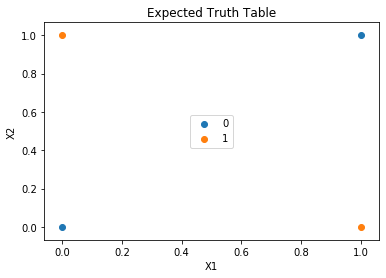

In [13]:
# Truth table 
TT = np.asarray([[0,0,0],    
                 [0,1,1], 
                 [1,0,1],
                 [1,1,0]])

### Visualise the truth table
# X values are first 2 cols, y is final col (output)
X = TT[:,:2]
y = TT[:,-1]
    
plt.title("Expected Truth Table")
plt.xlabel('X1')
plt.ylabel('X2')
    
# separate the X values by output (for coloring in plots)
X_zeros = X[y==0,:]
X_ones  = X[y==1,:]

# plot X values and color as y value
plt.scatter(X_zeros[:,0], X_zeros[:,1], label = '0')
plt.scatter(X_ones[:,0], X_ones[:,1], label = '1')  
plt.legend(loc='center')

plt.show()

100%|██████████| 500/500 [00:00<00:00, 1682.86it/s]


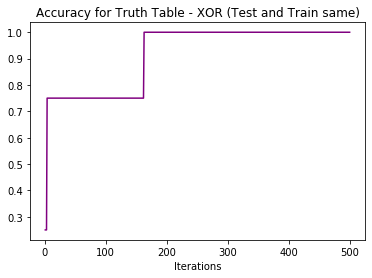

Highest accuracy => 1.0
Final Accuracy => 1.0
[[-1.87444123  1.56969203  1.74697976]
 [ 3.52268124 -2.66759849 -2.54859407]
 [ 0.9105199   0.41049253  0.05863355]
 [-0.71135594  1.52517275  0.78532078]
 [ 2.05722279 -1.53428733 -1.98884433]] [[ 0.60694197 -2.58809243  3.95269322 -0.36146276 -1.70261013  2.64975638]
 [-0.53316202  2.64347154 -4.18224367  0.0731629   1.85950613 -2.38301116]]


In [27]:
# Hyperparameters - tune here
params = {
    'n_hid'   : 5,
    'lr'      : 0.2,          
    'w_init'  : None,
    'w_scale' : 1,
    'n_iters' : 500, 
    'batch'   : False, 
    'bias'    : True
}

# Inputs: get X and y from truth table
X = TT[:,:2] # first two columns
y = TT[:,-1] # last column

# convert y to one hot encoding (for our network to be general for any number of output units)
y_OH = np.zeros((y.size, y.max()+1))
y_OH[np.arange(y.size),y.reshape(-1)] = 1

# call backprop function
# our architechture here is 2 ip units, 2 hidden units and 2 output units
# giving a total size of 6 weights from ip to hidden and 6 from hidden to output
w1,w2,accuracies = backprop(X,y_OH,params)

# print highest accuracy and display history
epochs = np.arange(1, len(accuracies)+1)
plt.plot(epochs, accuracies, c='purple')
plt.title('Accuracy for Truth Table - XOR (Test and Train same)')
plt.xlabel('Iterations')
plt.show()
print(f"Highest accuracy => {max(accuracies)}")
print(f"Final Accuracy => {accuracies[-1]}")
print(w1,w2)

##### Training the network for the circuit given
Now that we know the code is working properly, we move on to the actual question at hand. This is done by simply altering the truth table input to the network, as shown below.

In [67]:
# Truth table 
TT = np.asarray([[0,0,0,0],    
                 [0,0,1,0], 
                 [0,1,0,0],
                 [0,1,1,0],
                 [1,0,0,0],
                 [1,0,1,0],
                 [1,1,0,1],
                 [1,1,1,1],])

100%|██████████| 500/500 [00:00<00:00, 1832.19it/s]


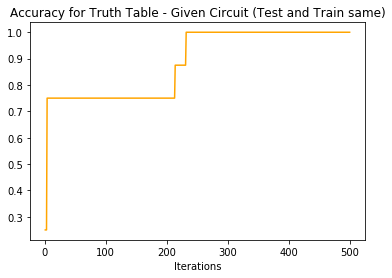

Highest accuracy => 1.0
Final Accuracy => 1.0
[[ 2.11469031 -2.29956678 -1.59271848  0.17429579]
 [-1.23649029  0.87109444  2.08326308  0.12220267]
 [ 3.47295782 -2.87045184 -2.60316723  0.24802713]] [[-0.60170216  2.62589895 -2.51670338  4.08051185]
 [ 0.44689173 -2.64602197  2.72236537 -4.04829402]]


In [68]:
# Hyperparameters - tune here
params = {
    'n_hid'   : 3,
    'lr'      : 0.2,          
    'w_init'  : None,
    'w_scale' : 1,
    'n_iters' : 500, 
    'batch'   : False, 
    'bias'    : True
}

# Inputs: get X and y from truth table
X = TT[:,:3] # first two columns
y = TT[:,-1] # last column

# convert y to one hot encoding (for our network to be general for any number of output units)
y_OH = np.zeros((y.size, y.max()+1))
y_OH[np.arange(y.size),y.reshape(-1)] = 1

# call backprop function
# our architechture here is 2 ip units, 2 hidden units and 2 output units
# giving a total size of 6 weights from ip to hidden and 6 from hidden to output
w1,w2,accuracies = backprop(X,y_OH,params)

# print highest accuracy and display history
epochs = np.arange(1, len(accuracies)+1)
plt.plot(epochs, accuracies, c='orange')
plt.title('Accuracy for Truth Table - Given Circuit (Test and Train same)')
plt.xlabel('Iterations')
plt.show()
print(f"Highest accuracy => {max(accuracies)}")
print(f"Final Accuracy => {accuracies[-1]}")
print(w1,w2)

As you can see, my neural network is able to perfectly classify all the required training samples from the truth table correctly, and training reaches convergence fairly early on.

##### Training AND gate to check implementation

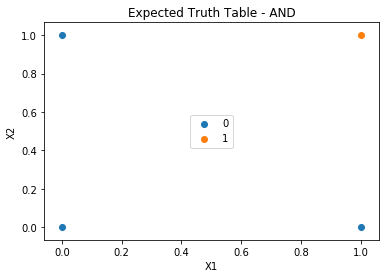

In [32]:
# Truth table 
TT = np.asarray([[0,0,0],    
                 [0,1,0], 
                 [1,0,0],
                 [1,1,1]])

### Visualise the truth table
# X values are first 2 cols, y is final col (output)
X = TT[:,:2]
y = TT[:,-1]
    
plt.title("Expected Truth Table - AND")
plt.xlabel('X1')
plt.ylabel('X2')
    
# separate the X values by output (for coloring in plots)
X_zeros = X[y==0,:]
X_ones  = X[y==1,:]

# plot X values and color as y value
plt.scatter(X_zeros[:,0], X_zeros[:,1], label = '0')
plt.scatter(X_ones[:,0], X_ones[:,1], label = '1')  
plt.legend(loc='center')

plt.show()

100%|██████████| 500/500 [00:00<00:00, 2926.27it/s]


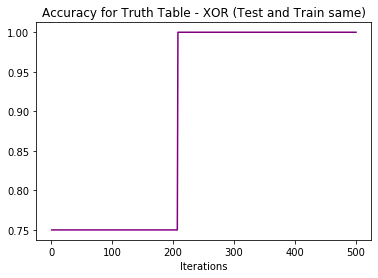

Highest accuracy => 1.0
Final Accuracy => 1.0
[[-1.25023463  2.29730781  2.32941215]
 [-0.79889756  1.38627331  1.74610972]
 [ 0.87827678 -1.13483499 -0.88705199]
 [ 0.20697502  1.02638244  0.72927155]
 [-1.4988017   2.7890172   2.82072692]] [[ 1.46834941 -1.96502605 -1.33361759  1.99122694 -0.07984877 -2.70250795]
 [-2.1025958   2.29593347  1.11525745 -1.31998855  0.25229191  2.85492782]]


In [34]:
# Hyperparameters - tune here
params = {
    'n_hid'   : 5,
    'lr'      : 0.2,          
    'w_init'  : None,
    'w_scale' : 1,
    'n_iters' : 500, 
    'batch'   : False, 
    'bias'    : True
}

# Inputs: get X and y from truth table
X = TT[:,:2] # first two columns
y = TT[:,-1] # last column

# convert y to one hot encoding (for our network to be general for any number of output units)
y_OH = np.zeros((y.size, y.max()+1))
y_OH[np.arange(y.size),y.reshape(-1)] = 1

# call backprop function
# our architechture here is 2 ip units, 2 hidden units and 2 output units
# giving a total size of 6 weights from ip to hidden and 6 from hidden to output
w1_AND,w2_AND,accuracies = backprop(X,y_OH,params)

# print highest accuracy and display history
epochs = np.arange(1, len(accuracies)+1)
plt.plot(epochs, accuracies, c='purple')
plt.title('Accuracy for Truth Table - XOR (Test and Train same)')
plt.xlabel('Iterations')
plt.show()
print(f"Highest accuracy => {max(accuracies)}")
print(f"Final Accuracy => {accuracies[-1]}")
print(w1_AND,w2_AND)

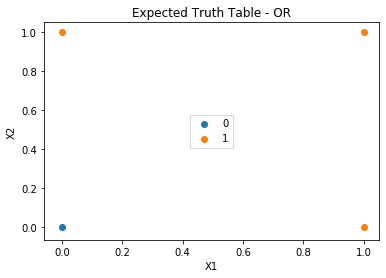

In [33]:
# Truth table 
TT = np.asarray([[0,0,0],    
                 [0,1,1], 
                 [1,0,1],
                 [1,1,1]])

### Visualise the truth table
# X values are first 2 cols, y is final col (output)
X = TT[:,:2]
y = TT[:,-1]
    
plt.title("Expected Truth Table - OR")
plt.xlabel('X1')
plt.ylabel('X2')
    
# separate the X values by output (for coloring in plots)
X_zeros = X[y==0,:]
X_ones  = X[y==1,:]

# plot X values and color as y value
plt.scatter(X_zeros[:,0], X_zeros[:,1], label = '0')
plt.scatter(X_ones[:,0], X_ones[:,1], label = '1')  
plt.legend(loc='center')

plt.show()

100%|██████████| 500/500 [00:00<00:00, 2798.65it/s]


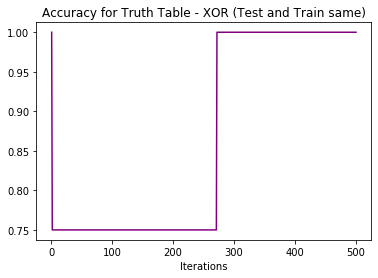

Highest accuracy => 1.0
Final Accuracy => 1.0
[[ 0.77529568  0.75357209  0.59537137]
 [-1.53428551  2.80840904  2.71347751]
 [-0.83997904  1.57654674  1.67575898]
 [-1.01238117  1.57645018  2.05908117]
 [-0.88810149  1.78383736  1.43240703]] [[ 2.49562187  0.05204325 -2.41494358 -1.52674909 -1.38619297 -0.78917378]
 [-2.47248894 -0.61221495  2.89137431  0.8198112   1.53872365  1.65201891]]


In [35]:
# Hyperparameters - tune here
params = {
    'n_hid'   : 5,
    'lr'      : 0.2,          
    'w_init'  : None,
    'w_scale' : 1,
    'n_iters' : 500, 
    'batch'   : False, 
    'bias'    : True
}

# Inputs: get X and y from truth table
X = TT[:,:2] # first two columns
y = TT[:,-1] # last column

# convert y to one hot encoding (for our network to be general for any number of output units)
y_OH = np.zeros((y.size, y.max()+1))
y_OH[np.arange(y.size),y.reshape(-1)] = 1

# call backprop function
# our architechture here is 2 ip units, 2 hidden units and 2 output units
# giving a total size of 6 weights from ip to hidden and 6 from hidden to output
w1_OR,w2_OR,accuracies = backprop(X,y_OH,params)

# print highest accuracy and display history
epochs = np.arange(1, len(accuracies)+1)
plt.plot(epochs, accuracies, c='purple')
plt.title('Accuracy for Truth Table - XOR (Test and Train same)')
plt.xlabel('Iterations')
plt.show()
print(f"Highest accuracy => {max(accuracies)}")
print(f"Final Accuracy => {accuracies[-1]}")
print(w1_OR,w2_OR)

These checks were added to show that our network is able to capture the basic logic gates needed.

# Question 2 - GABIL for Combinatorial Logic Circuit 
The circuit in the question is given above, same as the previous question. For this algorithm, an encoding of the data is needed. From the truth table, the output values (Y) for all 8 training samples will be considered as a binary string of length 8.

In [112]:
# Truth table 
TT = np.asarray([[0,0,0,0],    
                 [0,0,1,0], 
                 [0,1,0,0],
                 [0,1,1,0],
                 [1,0,0,0],
                 [1,0,1,0],
                 [1,1,0,1],
                 [1,1,1,1],])

X = TT[:,:3] # first two columns
Y = TT[:,-1] # last column

###### Make the initial population

In [113]:
# defining design parameters
num_chromosomes = 8
num_genes = 3

# The population will have `num_chromosomes` chromosome with each having `num_genes` genes.
population_size = (num_chromosomes, num_genes) 

# Creating the initial population.
new_population = numpy.random.uniform(low=-4.0, high=4.0, size=population_size)

##### Fitness Function
This is used to determine how good a certain member of the population is for passing on its genes to the future generations.
According to GABIL, `fitness(hypothesis h) = (percent correct)^2`

In [138]:
def calculate_fitness(population):
    ''' 
        Function to calculate fitness for all members of a given population
        It calculates the sum of products of each input and its respective weight
        
        low fitness value is better because the way I have taken makes it inverted for easier handling.
    '''
    # fitness to return - all 0s initially
    fitness = np.zeros(len(population))
    
    # go through each member
    for i in range(len(population)):
        error = 0
        
        # calculate error as defined
        for j in range(len(X)):
            error += np.square(np.dot(X[j],population[i]) - Y[j])
        error /= len(X)
        fitness[i] = error # append
        
    # print and return
    print(f"Fitness values => {fitness}")    
    return fitness

##### Function to select the best individuals for mating

In [172]:
def select_mating_pool(population, fitness, num_parents):
    '''
        Function to select the best members of the population that will pass on their genes
    '''

    # chosen parents
    parents = numpy.empty((num_parents, population.shape[1]))
    parentsidx = []
    
    # loop until we have desired number of parents
    for parent_num in range(num_parents):
        
        # find best - highest value of fitness 
        max_fitness_idx = np.argmin(fitness)
        parentsidx.append(max_fitness_idx)
        parents[parent_num, :] = population[max_fitness_idx, :]

        # boost its fitness so it doesnt come back
        fitness[max_fitness_idx] = 99999999999
        
    print("Best 4 members => ", parentsidx)

    return parents

##### 2 point crossover
This basically simulates mating between the chosen parents

In [173]:
def crossover(parents, offspring_size):
    '''
        Function to perform crossover of chosen parents
        This basically swaps the left and right halves accordingly
    '''
    
    # offspring 
    offspring = numpy.empty(offspring_size)
    
    # The point at which crossover takes place between two parents. Usually, it is at the center.
    crossover_point = numpy.uint8(offspring_size[1]/2)

    # until we have the required offspring, loop 
    for o in range(offspring_size[0]):
        # Index of the first parent to mate - % to loop back if required
        parent1_idx = o % parents.shape[0]
        
        # Index of the second parent to mate.
        parent2_idx = (o+1) % parents.shape[0]
        
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[o, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        
        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[o, crossover_point:] = parents[parent2_idx, crossover_point:]
        return offspring

##### Mutation
This basically represents the random mutations that might occur in genes.

In [174]:
def mutation(offspring_crossover):
    '''
        This function changes a single gene in each offspring randomly,
        according to a threshold of 0.1 (chosen) 
    '''
    # go through each offspring
    for idx in range(offspring_crossover.shape[0]):
        # check if mutation even occurs: - small chance
        if random.uniform(0, 1) > 0.1:
            continue
        
        # The random value to be added to the gene.
        random_value = numpy.random.uniform(-1.0, 1.0, 1)
        rnd = np.random.randint(offspring_crossover.shape[1])
        offspring_crossover[idx, rnd] = offspring_crossover[idx, rnd] + random_value
    
    print("4 offspring generated after mutation: ")
    print(offspring_crossover)
    return offspring_crossover

##### GA:
We perform fitness calculation, selection, crossover, and mutation in order repeatedly:

In [186]:
num_generations = 5 # basically iterations
num_parents_mating = 4

# 
for generation in range(num_generations):
    print(f"\n\n----------- Generation {generation} ---------------\n")
     # Measuring the fitness of each chromosome in the population.
    fitness = calculate_fitness(new_population)
    
    # Selecting the best parents in the population for mating.
    parents = select_mating_pool(new_population, fitness, num_parents_mating)

    # Generating next generation using crossover.
    offspring_crossover = crossover(parents, offspring_size=(pop_size[0]-parents.shape[0], num_weights))

    # Adding some variations to the offsrping using mutation.
    offspring_mutation = mutation(offspring_crossover)
    
    # Creating the new population based on the parents and offspring.
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation
    print("Updated population")
    print(new_population)




----------- Generation 0 ---------------

Fitness values => [0.09283217 0.11940483 0.11940483 0.11940483 0.11940483 0.11940483
 0.11940483 0.11940483]
Best 4 members =>  [0, 1, 2, 3]
4 offspring generated after mutation: 
[[0.54353698 0.03107727 0.00175498]
 [0.54353698 0.03107727 0.00175498]
 [0.54353698 0.03107727 0.00175498]
 [0.54353698 0.03107727 0.00175498]]
Updated population
[[ 0.54353698  0.28632417 -0.06651392]
 [ 0.54353698  0.03107727  0.00175498]
 [ 0.54353698  0.03107727  0.00175498]
 [ 0.54353698  0.03107727  0.00175498]
 [ 0.54353698  0.03107727  0.00175498]
 [ 0.54353698  0.03107727  0.00175498]
 [ 0.54353698  0.03107727  0.00175498]
 [ 0.54353698  0.03107727  0.00175498]]


----------- Generation 1 ---------------

Fitness values => [0.09283217 0.11940483 0.11940483 0.11940483 0.11940483 0.11940483
 0.11940483 0.11940483]
Best 4 members =>  [0, 1, 2, 3]
4 offspring generated after mutation: 
[[0.54353698 0.03107727 0.00175498]
 [0.54353698 0.03107727 0.00175498]
 [0

In [187]:
print("Final population => \n")
print(new_population)
scores = calculate_fitness(new_population)

Final population => 

[[ 0.54353698  0.28632417 -0.06651392]
 [ 0.54353698  0.17338543  0.00175498]
 [ 0.54353698  0.03107727  0.00175498]
 [ 0.54353698  0.03107727  0.00175498]
 [ 0.54353698  0.17338543  0.00175498]
 [ 0.54353698  0.03107727  0.00175498]
 [ 0.54353698  0.03107727  0.00175498]
 [ 0.54353698  0.03107727  0.00175498]]
Fitness values => [0.09283217 0.10159886 0.11940483 0.11940483 0.10159886 0.11940483
 0.11940483 0.11940483]


In [198]:
print("Best member of the final population:\nWeights => ", end="")
print(new_population[np.argmin(scores)])
print("score => ",scores[np.argmin(scores)])

Best member of the final population:
Weights => [ 0.54353698  0.28632417 -0.06651392]
score =>  0.09283217392600739


In [199]:
print("Final weights")
weights=new_population[np.argmin(scores)]
print(weights)

Final weights
[ 0.54353698  0.28632417 -0.06651392]


In [200]:
correct = 0
for i in range(len(X)):
    print("\nInput",X[i])
    print("Actual",Y[i])
    pred = np.dot(X[i],weights)
    pred = 1 if pred > 0.5 else 0
    print("Predicted",np.dot(X[i],weights), " => ", pred)
    if (Y[i] == pred):
        correct += 1

print(f"\n-----------\nAccuracy => {correct*100/len(X)}%")


Input [0 0 0]
Actual 0
Predicted 0.0  =>  0

Input [0 0 1]
Actual 0
Predicted -0.06651392191324668  =>  0

Input [0 1 0]
Actual 0
Predicted 0.28632416750946016  =>  0

Input [0 1 1]
Actual 0
Predicted 0.21981024559621348  =>  0

Input [1 0 0]
Actual 0
Predicted 0.5435369843151119  =>  1

Input [1 0 1]
Actual 0
Predicted 0.4770230624018652  =>  0

Input [1 1 0]
Actual 1
Predicted 0.829861151824572  =>  1

Input [1 1 1]
Actual 1
Predicted 0.7633472299113253  =>  1

-----------
Accuracy => 87.5%


#### <center>End of Exam, Thank you